In [1]:
!ls

dataset.zip  sample_data


In [2]:
import zipfile
zf = "./dataset.zip"
target_dir = "./datasets"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.layers import RandomZoom, RandomFlip, RandomRotation


base_dir = './datasets/alien_vs_predator_thumbnails/data'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

BATCH_SIZE = 8

IMG_HEIGHT = 224
IMG_WIDTH = 224

epochs = 100

In [5]:
train_dataset = image_dataset_from_directory(train_dir,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            label_mode="binary",
                                            color_mode='rgb',
                                            image_size=(IMG_HEIGHT, IMG_WIDTH))

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  label_mode="binary",
                                                  color_mode='rgb',
                                                  image_size=(IMG_HEIGHT, IMG_WIDTH))

class_names = train_dataset.class_names
print(class_names)

Found 694 files belonging to 2 classes.
Found 200 files belonging to 2 classes.
['alien', 'predator']


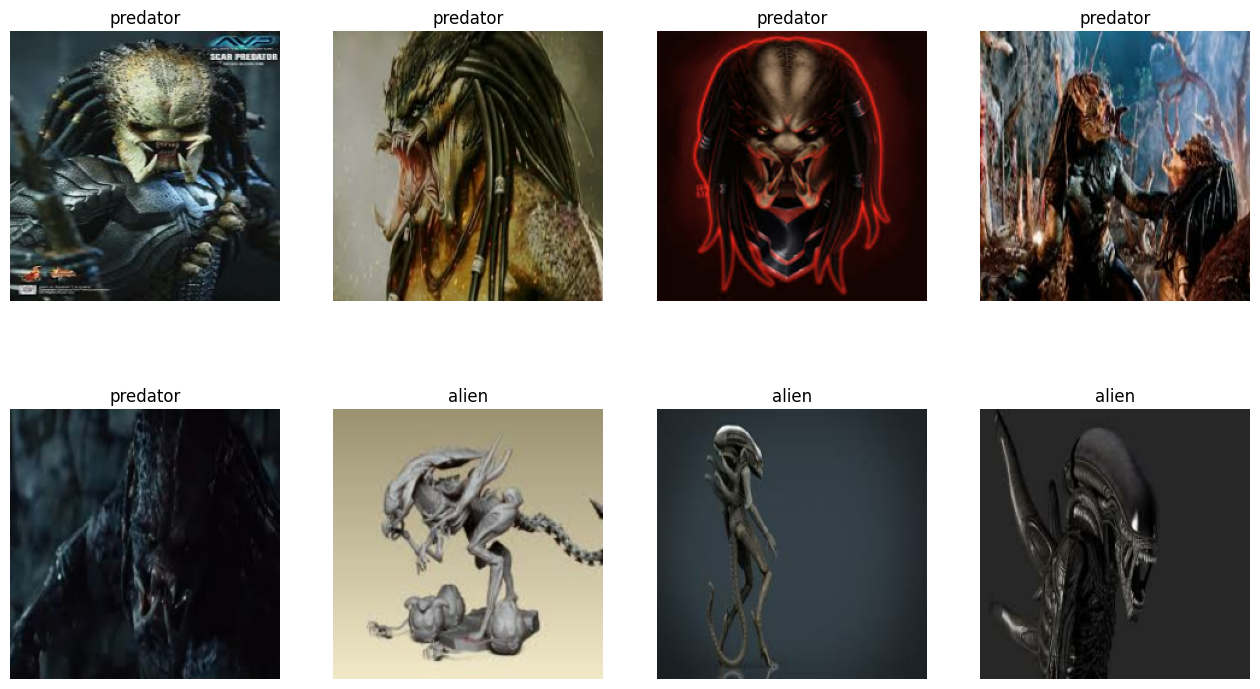

In [6]:
plt.figure(figsize=(16, 9))
for images, labels in train_dataset.take(1):
    for i in range(BATCH_SIZE):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

In [7]:
data_augmentation = Sequential(
  [
    RandomFlip(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), mode="horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1)
  ]
  , name="Augmentation"
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
data_augmentation.summary()

Model: "Augmentation"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 224, 224, 3)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Create Test Dataset
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [10]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 20
Number of test batches: 5


In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

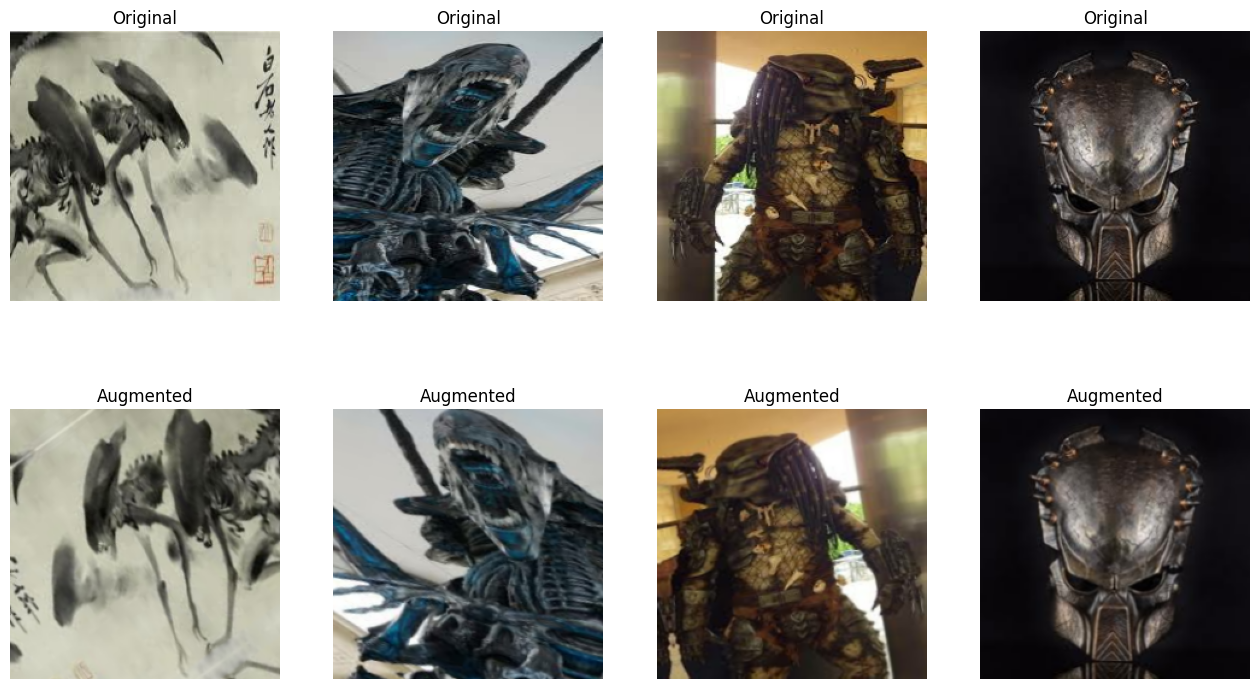

In [12]:
plt.figure(figsize=(16, 9))
for images, labels in train_dataset.take(1):
    argImg = data_augmentation(images)
    for i in range(int(BATCH_SIZE/2)):

        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("Original")
        plt.axis("off")

        plt.subplot(2, 4, i + 1 + int(BATCH_SIZE/2))
        plt.imshow(argImg[i].numpy().astype("uint8"))
        plt.title("Augmented")
        plt.axis("off")

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
import math

In [17]:
base_densenet_model = Sequential([
                        Rescaling(input_shape=(IMG_HEIGHT,IMG_WIDTH,3), scale=1.0/255, name="Rescaling"),
                        data_augmentation,
                        DenseNet201(input_shape=(IMG_HEIGHT,IMG_WIDTH,3), weights="imagenet", include_top=False)
], name="base_densenet_model")

base_densenet_model.trainable = False
base_densenet_model.summary()


custom_densenet_model = Sequential([
        base_densenet_model,
        GlobalAveragePooling2D(),
        Dropout(0.2),
        Dense(units=1, activation="sigmoid")
        ], name = "custom_densenet_model")

custom_densenet_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "base_densenet_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Augmentation (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet201 (Functional)        │ (None, 7, 7, 1920)     │    18,321,984 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,321,984 (69.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 18,321,984 (69.89 MB)

Model: "custom_densenet_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ base_densenet_model             │ (None, 7, 7, 1920)     │    18,321,984 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,921 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,323,905 (69.90 MB)

 Trainable params: 1,921 (7.50 KB)

 Non-trainable params: 18,321,984 (69.89 MB)

In [18]:
custom_densenet_model.compile(optimizer=Adam(learning_rate=0.001*3),
                         loss=BinaryCrossentropy(from_logits=False),
                         metrics=['accuracy']
                         )

In [21]:
# early stopping to monitor the validation loss and avoid overfitting
early = EarlyStopping(monitor="val_loss",
                      patience=math.floor(epochs*0.1))

# ReduceLROnPlateau to stabilize the training process of the model
learning_rate_reduction = ReduceLROnPlateau(monitor="val_loss",
                                            patience=2,
                                            verbose=1,
                                            factor=0.3,
                                            min_lr=0.000001)
# saves the model in the current directory as the best validation accuracy is achieved.
modelcheck = ModelCheckpoint('./best_model.keras', monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')

In [22]:
history = custom_densenet_model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs,
  callbacks=[modelcheck, learning_rate_reduction, early],
  verbose=1
)

Epoch 1/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.6621 - loss: 0.5797
Epoch 1: val_accuracy improved from -inf to 0.88125, saving model to ./best_model.keras
87/87 ━━━━━━━━━━━━━━━━━━━━ 44s 224ms/step - accuracy: 0.6635 - loss: 0.5780 - val_accuracy: 0.8813 - val_loss: 0.2760 - learning_rate: 0.0030
Epoch 2/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9201 - loss: 0.2370
Epoch 2: val_accuracy improved from 0.88125 to 0.90625, saving model to ./best_model.keras
87/87 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - accuracy: 0.9199 - loss: 0.2370 - val_accuracy: 0.9062 - val_loss: 0.2337 - learning_rate: 0.0030
Epoch 3/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8994 - loss: 0.2273
Epoch 3: val_accuracy improved from 0.90625 to 0.94375, saving model to ./best_model.keras
87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - accuracy: 0.8995 - loss: 0.2271 - val_accuracy: 0.9438 - val_loss: 0.1867 - learning_rate: 0.0030
Epoch 4/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/

<Axes: >

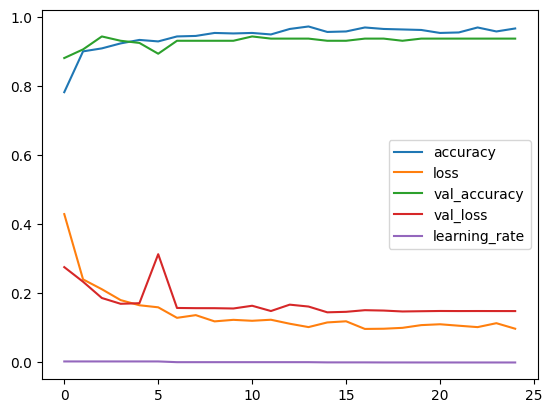

In [23]:
pd.DataFrame(custom_densenet_model.history.history).plot()

In [24]:
test_accu = custom_densenet_model.evaluate(test_dataset)

print("The testing accuracy is : ", test_accu[1]*100, "%")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9917 - loss: 0.0262
The testing accuracy is :  97.50000238418579 %


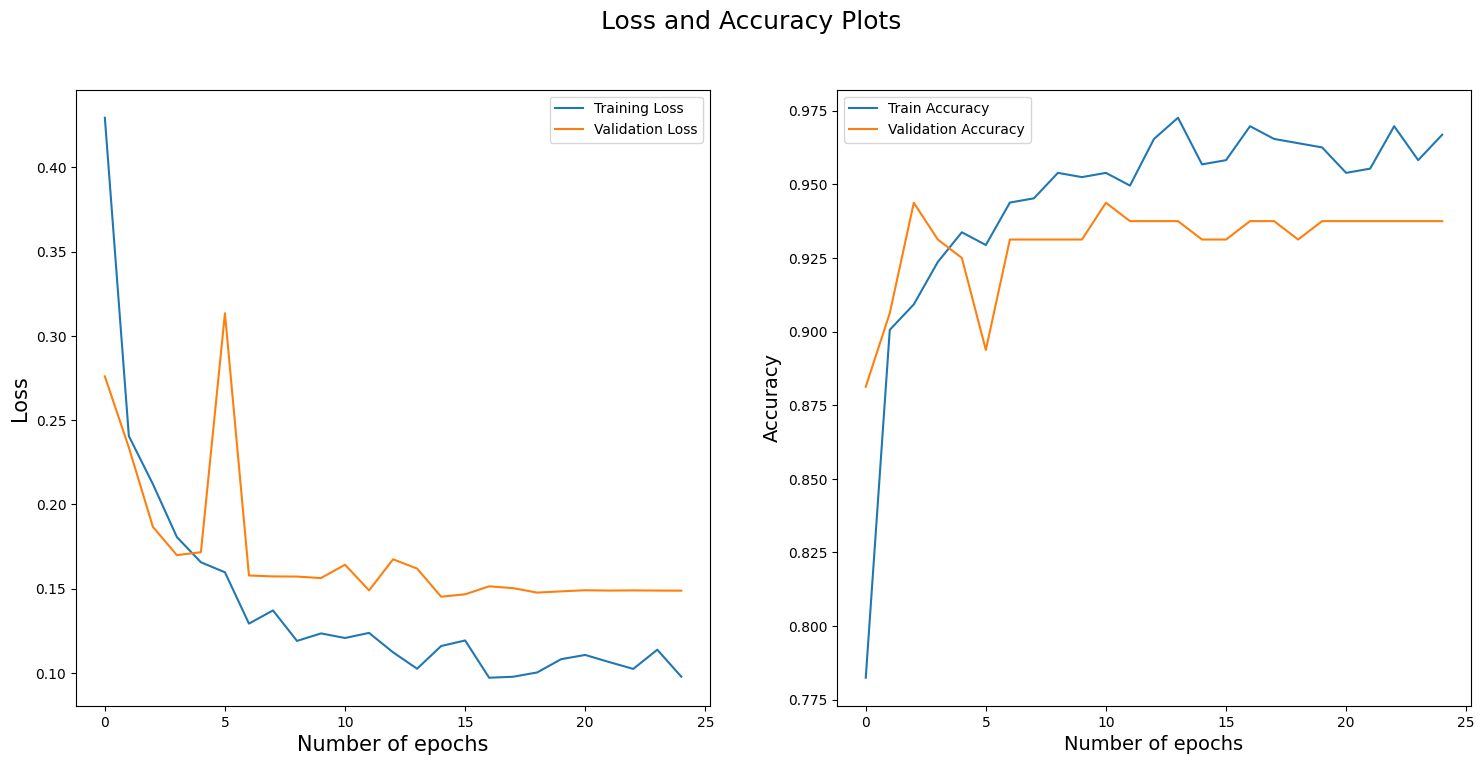

In [25]:
plt.figure(figsize=(18,8))

plt.suptitle('Loss and Accuracy Plots', fontsize=18)

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Number of epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.show()